# Introduction

This data is part of an experiment done by Dean Karlan and John A List, in which they test what factors contribute to donors of a nonprofit organization donating more / donating at all. They test several conditions, in which they send letters to donors beforehand and try to change suggested donation amounts / change the matching ratio (in which they promise that the donation will be matched by a specific multiple). The data contains all these treatment conditions as well as additional county level, demographic and politcal data related to the donors. 

In this analysis I will perform EDA to analyze the visual associations between variables, use machine learning techniques to identify if / whether features will be important and use statistical analyses to identify behavior across treatment conditions. I am interested in determining what factors or combination of factors, whether they are related to general demographic information or related to the various treatment conditions, inform a persons's decision to donate a specific amount (whether it is low or high).

**Note**: The EDA done in this notebook does not represent any personal views by the notebook author and is only meant to do pattern analysis. State and county level data in general is often missing, incorrect or vague and the paper authors did not perform the experiment on a large enough sample for it to be representative

# Background and related work
Before the authors, there has not been much background work done related to charitable giving in the philanthropic sense and how it is shaped by 'framing factors' such as the matching grant or matching ratio of the donation. The authors of the paper note that it has been observed in previous literature that increasing the price of donations (increasing the dollar amount) leads to lower donations.

According to the authors, under Andreoni's (1980) impure model, the presence of a matching gift may reduce the cost of donation (which can be thought of as a public good) and thus the demand for donation (increasing donations) may increase. However, that is a theoretical hypothesis. However, the authors also make note that such mechanisms may make individuals view the donation-seeking as a marketing ploy and distrust the donation drive, which could be harmful. 

This field experiment data provides enough data that these questions can be explored. 

# Research questions 
1. For the variables gender of donor and racial compostion of where the donor comes from, is there a relationship between these variables to the dependent variable of amount donation in a signficant way? If so, what is the relationship?
2. What variables in general are the most important when it comes to informing amount donated?
2. For the various treatment conditions (ratio of matching donation, donation amount suggested), is there an association with amount donated? 


# Methodology
This analysis is structured the following way
1. EDA 
2. Analysis
    - 2.1: Machine Learning
    - 2.2: Statistical analysis (for treatment conditions)

We can now move on to the analysis portion of the paper.

# Part 1: EDA and Data Processing

In [344]:
import pandas as pd
c = pd.read_csv('charitable.csv')

These preprocessing functions will create convient labels for the data and allow for ease of plotting.

In [230]:
def process_ratio(data):
    ratio_condition = None
    
    if data['treat_ratio2'] == 1:
        ratio_condition = '2:1 Ratio'
    elif data['treat_ratio3'] == 1:
        ratio_condition = '3:1 Ratio'
    else:
        ratio_condition = '1:1 Ratio'
        
    
    return ratio_condition 

def process_treatment(data):
    treatment_condition = None
    
    if data['treatment'] == 1:
        treatment_condition = 'Treatment 1'
    elif data['treatment'] == 0:
        treatment_condition = 'Treatment 2'
    
    return treatment_condition

def process_suggested_size(data):
    suggested_size = None
    
    if data['treat_askd1'] == 1:
        suggested_size = 'Suggested size : Highest previous contribution'
    elif data['treat_askd2'] == 1:
        suggested_size = 'Suggested size : 1.25 * Highest previous contribution'
    elif data['treat_askd3'] == 1:
        suggested_size = 'Suggested size : 1.50 * Highest previous contribution'
    return suggested_size

def process_state_info(data):
    state_aff = None
    if data['red0'] == 1:
        state_aff = 'Red'
    elif data['blue0'] ==1:
        state_aff = 'Blue'
    return state_aff 

def process_county_info(data):
    county_aff = None
    if data['redcty'] == 1:
        county_aff = 'Red'
    elif data['bluecty'] ==1:
        county_aff = 'Blue'
    return county_aff 



Applying the functions to a new copy of the data

In [231]:
c2 = c.copy()
c2['Ratio condition'] = c2.apply(lambda x: process_ratio(x), axis=1)
c2['Treatment condition'] =  c2.apply(lambda x: process_treatment(x), axis=1)
c2['Treatment size'] = c2.apply(lambda x: process_suggested_size(x), axis=1)
c2['Suggested donation size'] = c2.apply(lambda x: process_suggested_size(x), axis=1)
c2['State political affiliation'] = c2.apply(lambda x: process_state_info(x), axis=1)
c2['County political affiliation'] = c2.apply(lambda x: process_county_info(x), axis=1)

In [10]:
import matplotlib.pyplot as plt

## 1.1 : EDA of non-treatment variables

### County and state level political affiliation and race
We can try to see if there is any interaction between the percentage of white population versus the amount of 
donation, and also see if whether the county being blue or red (Democrat or Republican) affects donation amount.

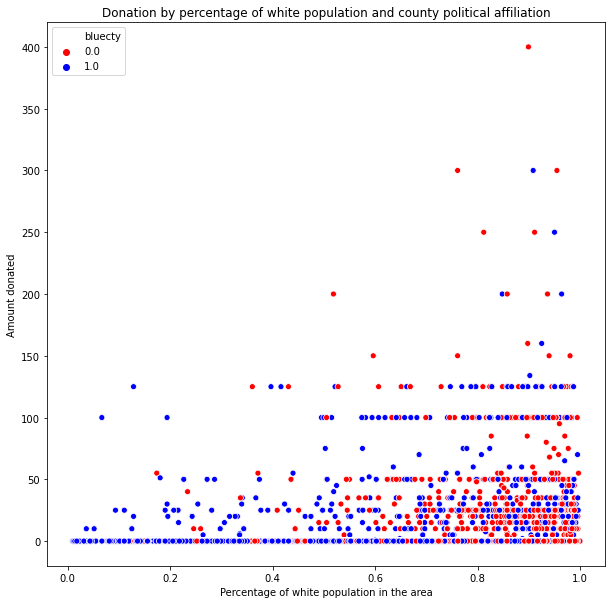

In [346]:
import seaborn as sns 
plt.figure(figsize=(10,10))
g =sns.scatterplot(x="pwhite", y="out_amountgive",
              hue="bluecty",
              data=c2, palette=['red', 'blue'])
plt.title('Donation by percentage of white population and county political affiliation')
plt.ylabel('Amount donated')
plt.xlabel('Percentage of white population in the area')
#plt.savefig('1.1.png')

From the graph, we can see that donors that come from a blue county come evenly from areas where the percentage of white population is low or high. On the other hand, donors that come in from the red county also come from areas where the percentage of white population is high. 

There does not seem to be any association between the county (red or blue) and donation amount. However, there is an association between the percentage of white population and donation amount. We can check whether this pattern holds at the state level

Text(0.5, 0, 'Percentage of white population in the area')

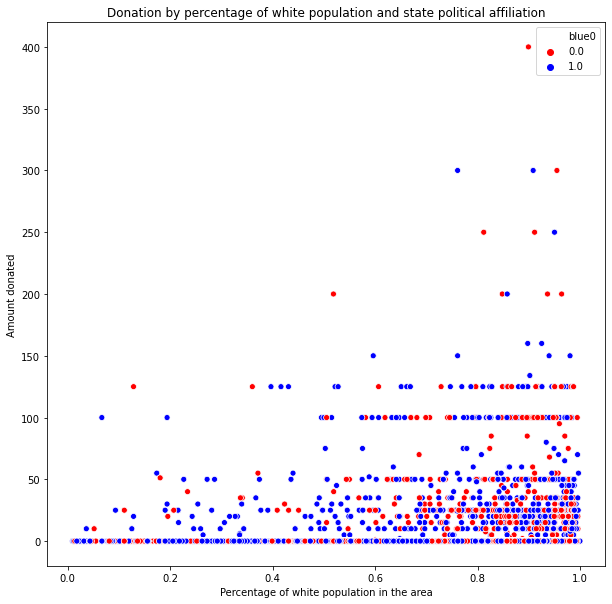

In [349]:
import seaborn as sns 
plt.figure(figsize=(10,10))
g =sns.scatterplot(x="pwhite", y="out_amountgive",
              hue="blue0",
              data=c, palette=['red', 'blue'])
plt.title('White vs. non-white spenders by county')
plt.title('Donation by percentage of white population and state political affiliation')
plt.ylabel('Amount donated')
plt.xlabel('Percentage of white population in the area')
#plt.savefig('1.2.png')


These graphs look almost identical, however, there are more donors that come from areas with low percentage of white population but Red (Republican) state affiliations. This makes sense as county level political associations and county level race distributions do not always correspond with the state, given how large and varied pockets of states can be. We can see that state level data here is not granular enough to give us specific information

### County and state level political affiliations and gender

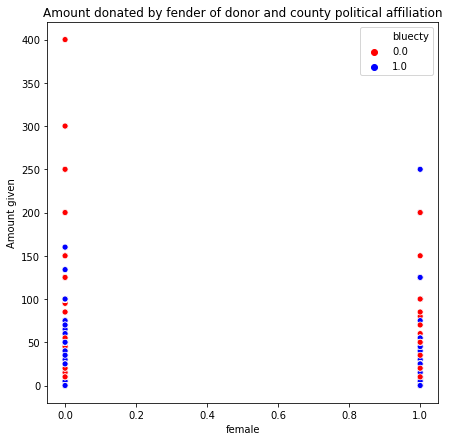

In [350]:
import seaborn as sns 
plt.figure(figsize=(7,7))
g =sns.scatterplot(x="female", y="out_amountgive",
              hue="bluecty",
              data=c, palette=['red', 'blue'])
plt.title('Amount donated by fender of donor and county political affiliation')
plt.ylabel('Amount given')
#plt.savefig('1.3.png')

From this graph we can see that male donors who donated high amounts (200$ and above) came from Red counties while those who voted a medium to a low amount had a roughly equal distribution of county affiliations. On the other hand, there did not seem to be a distinction between county level affiliation and female spending pattern, although females on the whole donated observably less than their male counterparts. 

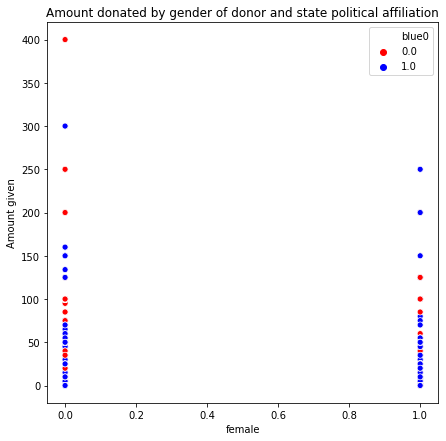

In [351]:
import seaborn as sns 
plt.figure(figsize=(7,7))
g =sns.scatterplot(x="female", y="out_amountgive",
              hue="blue0",
              data=c, palette=['red', 'blue'])
plt.title('Amount donated by gender of donor and state political affiliation')
plt.ylabel('Amount given')
#plt.savefig('1.4.png')

When looking at the same data but with state level political affiliation, we see an interesting pattern. Females that donated high amounts came from blue states, and blue states were highly represented in females vs. red states. However, males that donated high amounts hailed largely from red states.

### Gender and race

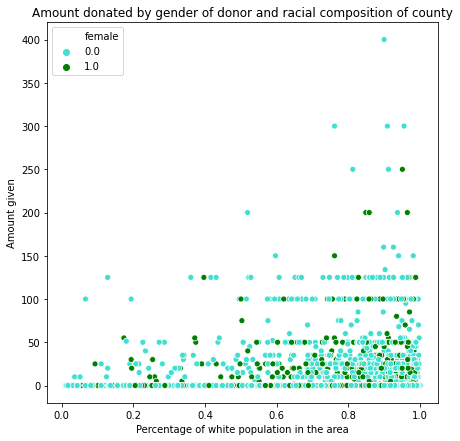

In [352]:
import seaborn as sns 
plt.figure(figsize=(7,7))
g =sns.scatterplot(x="pwhite", y="out_amountgive",
              hue="female",
              data=c, palette=['turquoise', 'green'])
plt.title('Amount donated by gender of donor and racial composition of county')
plt.ylabel('Amount given')
plt.xlabel('Percentage of white population in the area')
#plt.savefig('1.5.png')

We can see that female donors are more likely to come from areas where the percentage of white population is greater than 50%. In addition females largely donate less than 150 dollars.

### Gender and median household income

Text(0.5, 0, 'Median household income of the area')

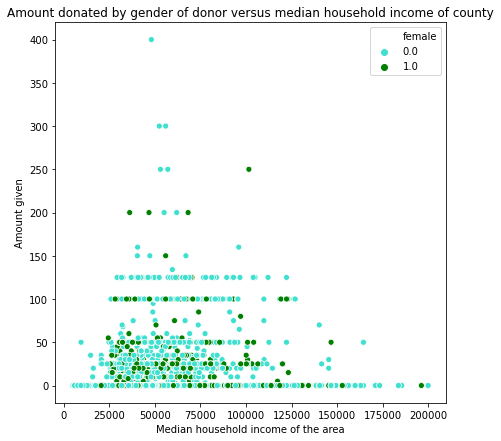

In [354]:
import seaborn as sns 
plt.figure(figsize=(7,7))
g =sns.scatterplot(x="median_hhincome", y="out_amountgive",
              hue="female",
              data=c, palette=['turquoise', 'green'])
plt.title('Amount donated by gender of donor versus median household income of county')
plt.ylabel('Amount given')
plt.xlabel('Median household income of the area')
#plt.savefig('1.6.png')

From the above graph, irrespective of gender, it is interesting to note that donors that come from areas with high median incomes of more than 110,000 USD are usually donating at the 0 USD level. On the other hand, when it comes to the donors that are coming from areas that have greater than 50,000$ income to 100,000 USD income are donating usually up to 50 dollars and some even beyond.

Female donators seem to donate irrespective of median household income.


### Frequency of donation and amount given

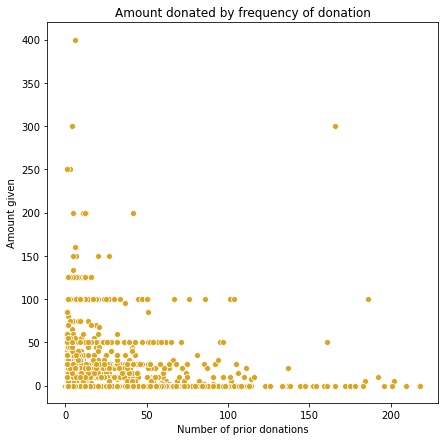

In [355]:
import seaborn as sns 
plt.figure(figsize=(7,7))
g =sns.scatterplot(x="freq", y="out_amountgive",
              data=c, color='goldenrod')
plt.title('Amount donated by frequency of donation')
plt.ylabel('Amount given')
plt.xlabel('Number of prior donations')
#plt.savefig('1.7.png')

From the above scatterplot, we observe that those donors who donate extremely frequently (more than 100 times) either donated nothing, or donated less than 50 USD unless they were outliers.

On the other hand, donors who donated infrequently were more likely to donate in high amounts usually reaching 100 USD but even as much as 400 USD. This shows that some donors may prefer breaking up their donations across several rounds of donations.

### Highest previous donation and amount given

Text(0.5, 0, 'Highest previous donation')

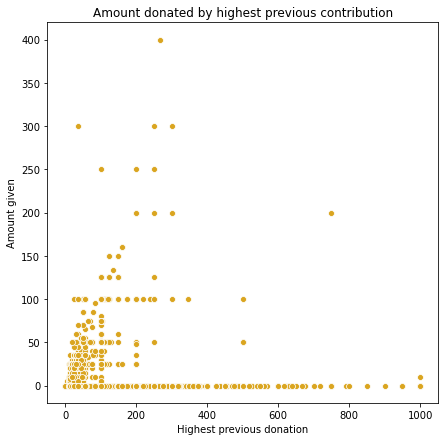

In [357]:
import seaborn as sns 
plt.figure(figsize=(7,7))
g =sns.scatterplot(x="hpa", y="out_amountgive",
              data=c, color='goldenrod')
plt.title('Amount donated by highest previous contribution')
plt.ylabel('Amount given')
plt.xlabel('Highest previous donation')
#plt.savefig('1.8.png')

From the scatterplot above, we can see that in line with the previous graphs, those with very high previous contributions are unlikely to donate more than 0 dollars. However, those with previous donations as high as 200 USD can donate up to as much as 400 dollars. This could also be a form of donation spreading done by donors.

### Percentage of population that are homeowners

Text(0.5, 0, 'Percentage of population that are homeowners')

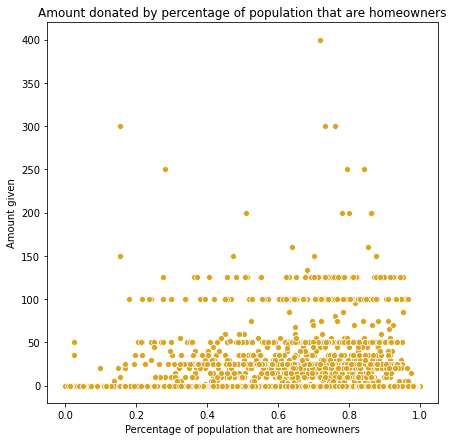

In [359]:
import seaborn as sns 
plt.figure(figsize=(7,7))
g =sns.scatterplot(x="powner", y="out_amountgive",
              data=c, color='goldenrod')
plt.title('Amount donated by percentage of population that are homeowners')
plt.ylabel('Amount given')
plt.xlabel('Percentage of population that are homeowners')
#plt.savefig('1.9.png')

### Time since last donation

Text(0, 0.5, 'Percentage of population that are homeowners')

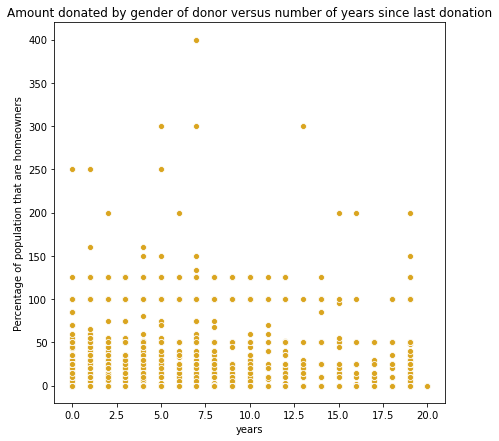

In [361]:
import seaborn as sns 
plt.figure(figsize=(7,7))
g =sns.scatterplot(x="years", y="out_amountgive",
              data=c[c.years< 40], color='goldenrod')
plt.title('Amount donated by gender of donor versus number of years since last donation')
plt.ylabel('Amount given')
plt.ylabel('Percentage of population that are homeowners')
#plt.savefig('1.10.png')

From the above, it seems like the number of years since initial donation does not have too much of an impact on the amount donated, although those who donated within the last 7.5 years seem to be donating more than the average amounts of 150 dollars by the visualization. We can check if this pattern holds with the number of months since previous donation. 

Text(0, 0.5, 'Percentage of population that are homeowners')

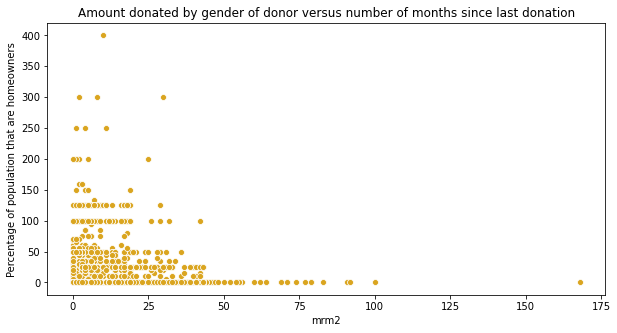

In [363]:
import seaborn as sns 
plt.figure(figsize=(10,5))
g =sns.scatterplot(x="mrm2", y="out_amountgive",
              data=c, color='goldenrod')
plt.title('Amount donated by gender of donor versus number of months since last donation')
plt.ylabel('Amount given')
plt.ylabel('Percentage of population that are homeowners')
#plt.savefig('1.11.png')

It looks like those people who last donated more than 40 months ago are unlikely to donate, while those who donated within the last 20 months are likely to donate a high amount. 

## 1.2: EDA of treatment variables

Text(0, 0.5, 'Treatment condition of donor')

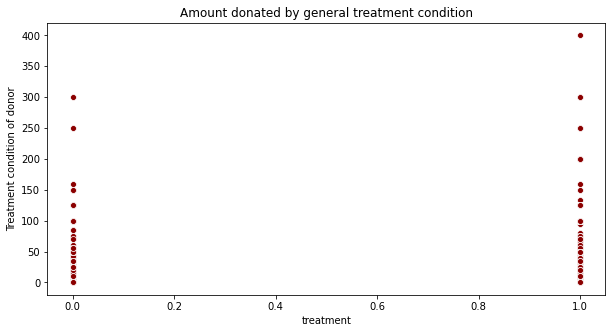

In [365]:
import seaborn as sns 
plt.figure(figsize=(10,5))
g =sns.scatterplot(x="treatment", y="out_amountgive",
              data=c, color='darkred')
plt.title('Amount donated by general treatment condition')
plt.ylabel('Amount given')
plt.ylabel('Treatment condition of donor')
#plt.savefig('1.12.png')

It seems those who receive the treatment conditions (matching ratio information, donation suggestion size) donate a higher amount than those who do not.

Text(0.5, 0, 'Treatment condition of donor')

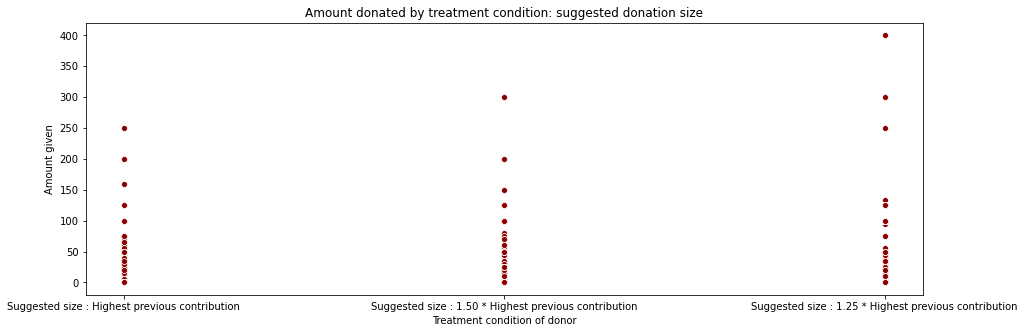

In [367]:
import seaborn as sns 
plt.figure(figsize=(15,5))
g =sns.scatterplot(x="Suggested donation size", y="out_amountgive",
              data=c2, color='darkred')
plt.title('Amount donated by treatment condition: suggested donation size')
plt.ylabel('Amount given')
plt.xlabel('Treatment condition of donor')
#plt.savefig('1.13.png')

Within the treatment conditions, it seems that those who have the suggested donation amount of 1.25 times the highest previous contribution donate more than those who are suggested to donate the same as a highest previous contribution amount, or those who are suggested 1.5 * the highest previous contribution.

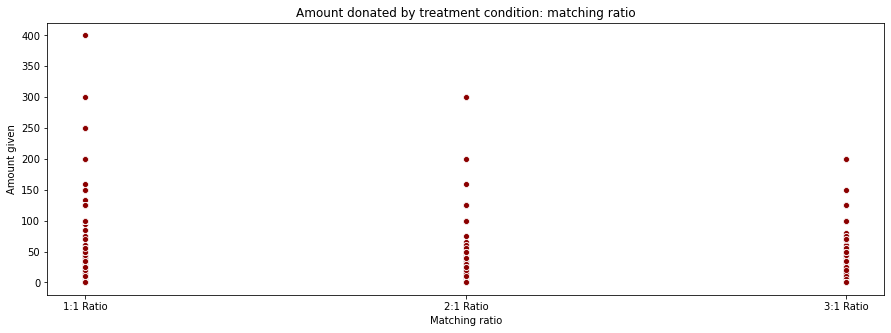

In [368]:
import seaborn as sns 
plt.figure(figsize=(15,5))
g =sns.scatterplot(x="Ratio condition", y="out_amountgive",
              data=c2, color='darkred')
plt.title('Amount donated by treatment condition: matching ratio')
plt.ylabel('Amount given')
plt.xlabel('Matching ratio')
#plt.savefig('1.14.png')

It seems that those who get the 1:1 Matching Ratio treatment donate more than those who receive a higher matching ratio treatment. 

# Part 2: Analysis 
We will now use various statistical and machine learning based methods to highlight what variables contribute to both the amount of donations given and whether members give donations at all. 

First we use the missingno library to visualize missing variables in the data.

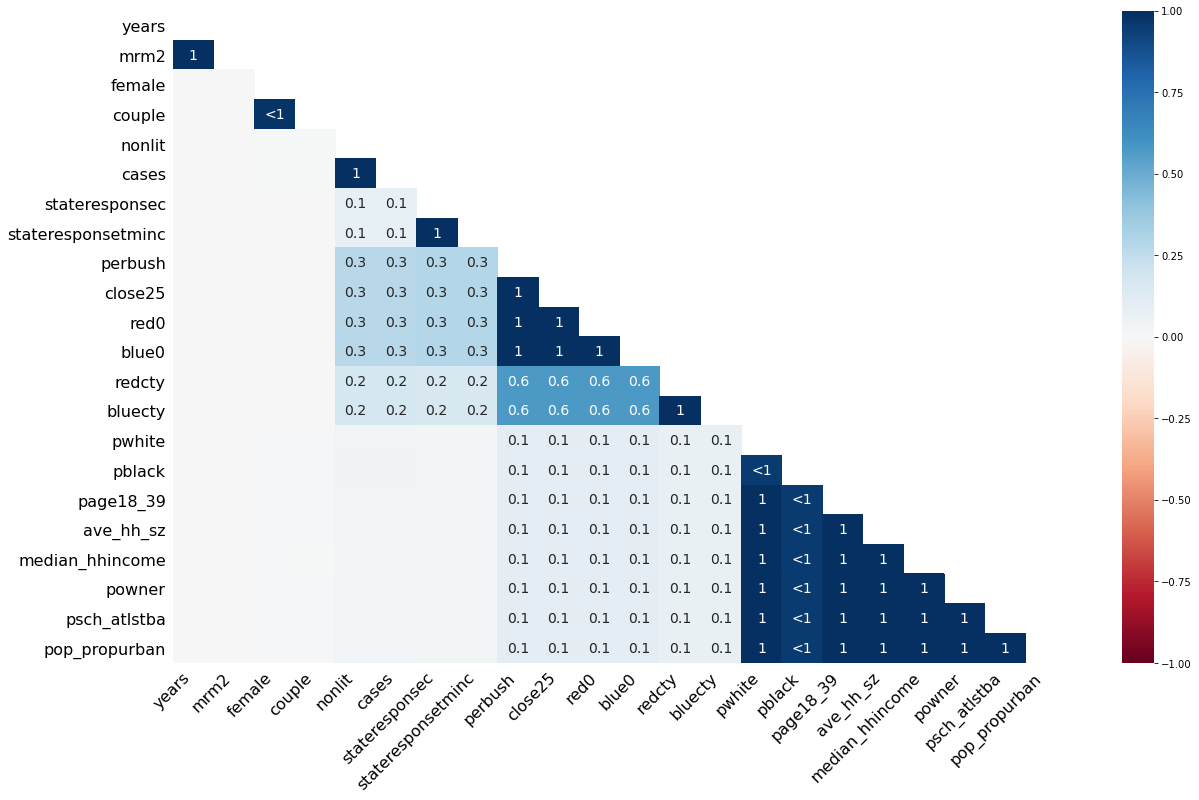

In [372]:
import missingno as msno
msno.heatmap(c)
#plt.savefig('2.1.png')

We can see that when it comes to demographics related to county, state and household information, there are some missing variables that are positively correlated with one another. We may have to correct for these in our analysis. 

## Part 2.1: Machine Learning Analysis
We can use various techniques in machine learning such as Random Forests, Linear Regression, Logistic Regression and others to highlight what contributes to likelihood of giving donation and amount of charitable donations given. Along with these, we also use metrics to score our models and check model performanes and validity.

### 2.1. A: Linear Regression using statsmodels and scikit-learn

We use two methods of performing linear regression, using the statsmodels and scikit-learn libraries to check the relationship between various independent variables and our dependent variable *out_amountgive* or the amount given in charitable donations.

In [373]:
def generate_data(data, mode='full'):
    """
    Function to generate both only demographic and full data for purposes of regression.
    This function also removes missing variables.
    """
    Y_col = ['out_amountgive']
    noise_cols = ['out_gavedum', 'out_changeamtgive']
    
    data = data.copy()
    data.dropna(inplace=True)
    
    # getting only demographic information
    if mode=='demographic':
        keep_cols = ['treatment', 'female', 'dormant', 'couple', 'median_hhincome', 'powner', \
            'red0', 'blue0', 'redcty', 'bluecty', 'pwhite', 'page18_39', 'ave_hh_sz', 
            'median_hhincome', 'pop_propurban']
        X = data[keep_cols]
        #X = X.drop(columns=noise_cols)
        Y = data[Y_col]
        return X, Y
    
    # Getting full information
    elif mode=='full':
        X = data.drop(columns=Y_col)
        X = X.drop(columns=noise_cols)
        Y = data[Y_col]
        return X, Y
        
        

First we generate the full data from the charitable donations csv file. We perform train test split and also apply preprocessing though the StandardScaler module to make sure our data is suitable for plugging into the Linear Regression module. 

In [374]:

X, Y  = generate_data(c)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test =sc.transform(X_test)

from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

print("R squared /variance for full data: ", linear_reg.score(X_test,y_test))
print('')
print("Residual sum of squares for full data: %.2f"
              % np.mean((linear_reg.predict(X_test) - y_test) ** 2))

R squared /variance for full data:  0.006534113037262368

Residual sum of squares for full data: 79.13


We can see that the full data does not explain the amount given in charitable donations very well. The R squared is 0.005 and the residual sum of squares is large. This is to be expected as a lot of the charitable contributions csv data is composed of state and county level variables and few variables are specific to the donors. 

We can now run the model on demographic variables (excluding treatment variables such as treatment condition, donation suggestion size condition etc.) Expectedly, the results from this model will make our R squared drop further and our Residual sum of squares to increase.


In [375]:
# generating demographic data. 
X_d, Y_d  = generate_data(c, mode='demographic')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, Y_d, test_size=0.3)
sc = StandardScaler()
X_train_d = sc.fit_transform(X_train_d)
X_test_d =sc.transform(X_test_d)

from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train_d, y_train_d)

print("r2/variance for demographic data: ", linear_reg.score(X_test_d,y_test_d))
print('')
print("Residual sum of squares for demographic data: %.2f"
              % np.mean((linear_reg.predict(X_test_d) - y_test_d) ** 2))

r2/variance for demographic data:  0.000961231449721045

Residual sum of squares for demographic data: 91.31


Thus when we put only the demograhic data, the explained variance decreases to 0.002  and the residual 
sum of squares increases to 80. However, it is not much worse than the metrics of the previous regression model.

We can try running the statsmodel version of the full regression and observe coefficients as well as plot for model fit. 

In [376]:
# Using statsmodels
from statsmodels.formula.api import ols

c_stats = c.dropna()# removing null values 

# creating the formula
indep_columns = "+ ".join(c_stats.columns.difference(['out_amountgive', 'out_gavedum', 'out_changeamtgive']))
formula = 'out_amountgive ~' + indep_columns
linear_model = ols(formula, data=c).fit()

In [377]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         out_amountgive   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     14.49
Date:                Sun, 31 Jan 2021   Prob (F-statistic):           3.05e-89
Time:                        16:28:41   Log-Likelihood:            -1.6680e+05
No. Observations:               46513   AIC:                         3.337e+05
Df Residuals:                   46475   BIC:                         3.340e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.8069      1.055      0.765      0.445      -1.262       2.876
ave_hh_sz             -0.3036      0.194     -1.565      0.118      -0.684       0.077
blue0                  0.3650      0.524      0.696      0.486      -0.663       1.393
bluecty               -0.4976      1.282     -0.388      0.698      -3.009       2.014
cases                  0.0298      0.049      0.602      0.547      -0.067       0.127
close25               -0.1099      0.129     -0.854      0.393      -0.362       0.142
couple                -0.3414      0.144     -2.377      0.017      -0.623      -0.060
dormant               -0.1993      0.118     -1.683      0.092      -0.431       0.033
female                -0.1385      0.093     -1.495      0.135      -0.320       0.043
freq                   0.0622      0.005     12.965      0.000       0.053       0.072
hpa                    0.0055      0.001      8.681      0.000       0.004       0.007
ltmedmra              -0.5763      0.087     -6.616      0.000      -0.747      -0.406
median_hhincome     6.699e-06   4.31e-06      1.553      0.120   -1.76e-06    1.52e-05
mrm2                  -0.0202      0.005     -4.088      0.000      -0.030      -0.011
nonlit                -0.0183      0.031     -0.585      0.558      -0.080       0.043
page18_39              0.6174      0.676      0.914      0.361      -0.707       1.942
pblack                -0.1863      0.630     -0.295      0.768      -1.422       1.049
perbush               -0.0426      0.874     -0.049      0.961      -1.755       1.670
pop_propurban          0.0631      0.191      0.331      0.741      -0.311       0.437
powner                 0.8677      0.500      1.734      0.083      -0.113       1.849
psch_atlstba          -0.2661      0.483     -0.550      0.582      -1.214       0.681
pwhite                -0.8313      0.639     -1.300      0.194      -2.085       0.422
red0                   0.4856      0.550      0.882      0.378      -0.593       1.565
redcty                -0.4258      1.281     -0.332      0.740      -2.936       2.084
state50one             2.7595      1.383      1.995      0.046       0.049       5.470
statecnt               0.0043      0.013      0.326      0.744      -0.022       0.030
stateresponse        199.3265    155.199      1.284      0.199    -104.865     503.518
stateresponsec     -3.877e+07   1.12e+08     -0.347      0.729   -2.58e+08     1.8e+08
stateresponset      3.877e+07   1.12e+08      0.347      0.729    -1.8e+08    2.58e+08
stateresponsetminc -3.877e+07   1.12e+08     -0.347      0.729   -2.58e+08     1.8e+08
treat_askd1         2026.5480   5843.291      0.347      0.729   -9426.390    1.35e+04
treat_askd2         2026.6002   5843.291      0.347      0.729   -9426.337    1.35e+04
treat_askd3         2026.5844   5843.2

In [378]:
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:         out_amountgive   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     14.49
Date:                Sun, 31 Jan 2021   Prob (F-statistic):           3.05e-89
Time:                        16:28:49   Log-Likelihood:            -1.6680e+05
No. Observations:               46513   AIC:                         3.337e+05
Df Residuals:                   46475   BIC:                         3.340e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.8069      1

Interpetation of statsmodels results:

We can see that the R-squared adjusted is 0.01, which mean our explanatory features explain our model poorly. However, this is an improvement from the scikit-learn metrics. In addition, the size of the F-statistic is large and the associated p value is low. That means that at least one of the explanatory variables is significantly different from 0 if we choose our significance level to be 0.05.

Out of the above variables, the p-values of the following variables were less than the chosen significance
level of 0.05:

- couple (whether the donors were part of a couple)
- freq (number of prior donations)
- hpa (highest previous contribution)
- years (number of years since initial donation)
- mrm2 (number of months since initial donation)

Out of these variables, couple had a negative coefficent as well as years and months since last donation. This implies that those who have very recently donated or those who are part of a couple may donate slightly less. On the other hand, frequency and highest previous contribution had positive coefficients. This implies that those who donate frequently and those whose previous donation is high are also likely to donate more.  

On the other hand none of the demographic variables like:
- female (whether the donor is a female), 
- the percentage of people in the county that were homeowners
- the percentage of people in the county that were black
- The average household size of the county 
- The percentage of people who voted for bush in the previous election

were significant. This is likely because they are not specific to the donor observation.

However, we can see that there is a large variation in explanatory coefficients. The model summary 
also notes the presence of multicolinearity. Let us first examine the diagnostic plots of the above model to
confirm.

We can also use the statsmodel to test for the assumptions of normality, equal variance and linearity. 

Text(0.5, 1.0, 'Residual vs fit plot')

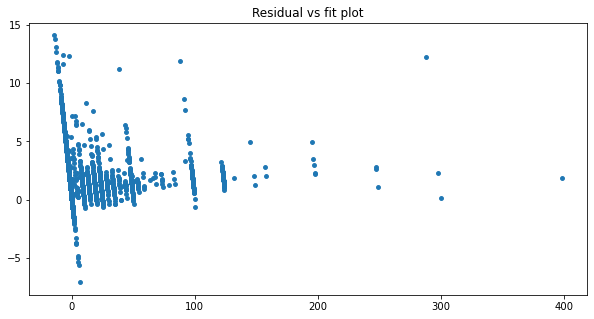

In [380]:
import matplotlib.pyplot as plt
pred_val = linear_model.fittedvalues.copy()
true_val = c_stats['out_amountgive'].values.copy()
residual = true_val - pred_val # The residuals of our model
fig, ax = plt.subplots(figsize=(10,5))
_ = ax.scatter(residual, pred_val, s=15)
plt.title('Residual vs fit plot')
#plt.savefig('2.2.png')

From the above we can see a somewhat linear pattern, however our errors do not look normal enough. We can see the sample below for what a residual vs. fit plot should look like. 

Text(0.5, 1.0, 'Residual vs fit plot example')

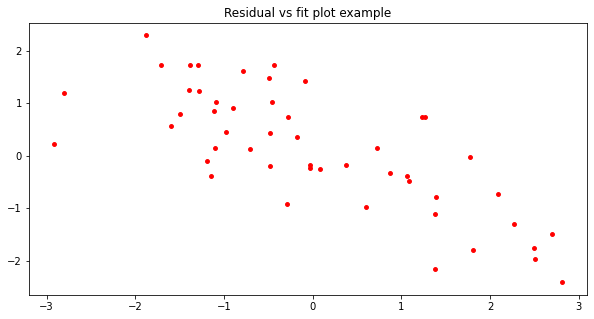

In [382]:
true_example = np.random.normal(loc=0.0, scale=1.0, size=50)
pred_example = np.random.normal(loc=0.0, scale=1.0, size=50)
residual_example = true_example - pred_example
fig, ax = plt.subplots(figsize=(10,5))
_ = ax.scatter(residual_example, pred_example, s=15, color='r')
plt.title('Residual vs fit plot example')
#plt.savefig('2.3.png')

While we are making plots of fit, we can also plot the errors and see whether they are normal or not. 

In [384]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

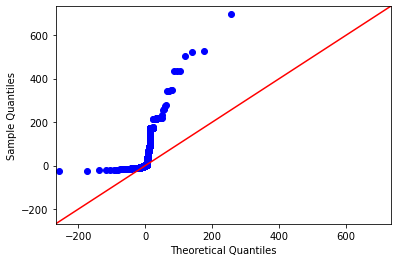

In [387]:
import statsmodels.api as sm
from scipy import stats

# Plotting the quantile-quantile plot
# sm.qqplot(residual, line='q')
figure = sm.graphics.qqplot(residual, dist=stats.t, line='45', fit=True)
figure.show()
#plt.savefig('2.4.png')

Thus the errors in our model are also not normally distributed. We can also use several statistical tests from statsmodels library to formally check these conditions. One of these is the Breusch-Pagan test for Heterosckedasticity. The null hypothesis for this test is that the error variances of the regression are all equal.

In [386]:
import statsmodels.stats.api as sms
_, pval, _,_ = sms.het_breuschpagan(linear_model.resid, linear_model.model.exog)
print('The p value for the test for heterosckedasticity is ', round(pval, 5))

The p value for the test for heterosckedasticity is  0.0


As this p value is less than our significance level of 0.05, we reject the null hypothesis and conclude that the error variances are not equal

From the end of the regression results, we also get the warning of multicolinearity, which could also skew our results and should be corrected. To observe multicolinearity we can check 

In [21]:
import numpy as np
round(np.linalg.cond(linear_model.model.exog), 5)

6.783750959229547e+20

This large value indicates that there is multicolinearity or linear dependence in the model. We can also verify this using a heatmap of the pairwise correlation of columns in our data.

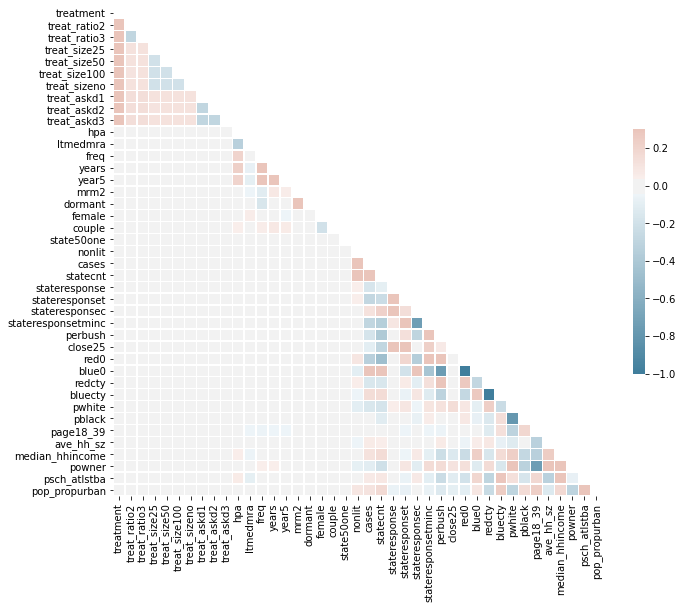

In [389]:
import matplotlib.pyplot as plt
import seaborn as sns

X, _ = generate_data(c)
corr = X.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#plt.savefig('2.5.png')

While the correlations are not too bad, we can observe correlations between some variables and may want to remove them and re-run the regression. To correct for the other errors in this linear regression, we can also use transformation to correct the violation of the linearity assumptions. 

### 2.1. B: Logistic Regression using scikit-learn
We also have another column in our data that indicates whether an individual gives a donation at all as a binary variable. We can proceed to use logistic regression to predict the likelihood of giving. 

In [391]:
def generate_logistic_data(data, mode='full'):
    """
    Function to generate the X and Y data for the logistic regression and remove noise columns. 
    """
    Y_col = 'out_gavedum'
    data = data.dropna()
    noise_cols = ['out_amountgive', 'out_changeamtgive']
    X = data.drop(columns=Y_col)
    X = X.drop(columns=noise_cols)
    Y = data[Y_col]
    return X, Y

In [392]:
X, Y  = generate_logistic_data(c)


We can also plot the distributions of observations in the Y variable to see the number of occurences of each class.

Text(0, 0.5, 'Frequency of occurence')

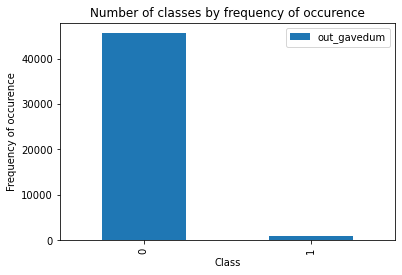

In [394]:
pd.DataFrame(Y.value_counts()).plot(kind='bar', label=None)
plt.title('Number of classes by frequency of occurence')
plt.xlabel('Class')
plt.ylabel('Frequency of occurence')
#plt.savefig('2.6.png')

We can see that there is class imbalance from the above plot. This means that we have the option of stratifying data according to the label column as well as performing oversampling to create more observations to learn from both classes. Based on stratifying and oversampling, we have 4 total conditions that we can test.

Here, the suffixes *s* and *ns* will refer to stratified and not stratified and similarly as *o* and *no* for the oversampled data

In [158]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, Y, test_size=0.3, stratify=Y)
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X, Y, test_size=0.3)

In [145]:
X_train_ns.shape, y_train_ns.shape

((32559, 41), (32559,))

We use the imblearn library to perform oversampling with random state 2.

In [395]:
import imblearn
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)

In [396]:
# Stratified and oversampled, test on X_test_s and y_train_s
X_train_s_o,  y_train_s_o = sm.fit_sample(X_train_s, y_train_s.ravel())

# Stratified and non-oversampled, test on X_test_s and y_train_s
X_train_s_no, y_train_s_no = X_train_s, y_train_s

# Not stratified and oversampled, test on X_test_ns and y_train_ns
X_train_ns_o, y_train_ns_o = sm.fit_sample(X_train_ns, y_train_ns.ravel())

# Not stratified and not oversampled, test on X_test_ns and y_train_ns
X_train_ns_no, y_train_ns_no = X_train_ns, y_train_ns



In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [75]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [165]:
def get_logistic_metrics(train_X, train_Y, test_X, test_Y, msg):
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(train_X, train_Y)
    preds = log_reg.predict(test_X)
    print(msg)
    print('')
    print('Accuracy is ', round(accuracy_score(test_Y, preds), 3))
    print('')
    print('F1 score is ', round(f1_score(test_Y, preds,4)) )
    print('')
    print('Recall is ', round(recall_score(test_Y, preds),3) )
    print('')
    print('Precision is ', round(precision_score(test_Y, preds),3) )
    

In [166]:
statement = 'Metrics for oversampled and stratified data:'
get_logistic_metrics(X_train_s_o, y_train_s_o, X_test_s, y_test_s, msg=statement)

Metrics for oversampled and stratified data:

Accuracy is  0.711

F1 score is  0.0

Recall is  0.522

Precision is  0.038


In [167]:
statement = 'Metrics for stratified and non oversampled data:'
get_logistic_metrics(X_train_s_no, y_train_s_no, X_test_s, y_test_s, msg=statement)

Metrics for stratified and non oversampled data:

Accuracy is  0.979

F1 score is  0.0

Recall is  0.007

Precision is  0.25


In [168]:
statement = 'Metrics for non-stratified and oversampled data:'
get_logistic_metrics(X_train_ns_o, y_train_ns_o, X_test_ns, y_test_ns, msg=statement)

Metrics for non-stratified and oversampled data:

Accuracy is  0.608

F1 score is  0.0

Recall is  0.664

Precision is  0.036


In [163]:
statement = 'Metrics for non-stratified and non-oversampled data:'
get_logistic_metrics(X_train_ns_no, y_train_ns_no, X_test_ns, y_test_ns, msg=statement)

Metrics for non-stratified and non-oversampled data:

Accuracy is  0.978

F1 score is  0.0

Recall is  0.01

Precision is  0.333


We can see that the F1 score for all the models is close to 0, so it does not help us discern which is a beter model.
on the other hand, the accuracy for the model with no stratification and no oversampling is high. Thus we choose that model.

For that specific model, we can use Grid Search techniques to find the best combination of parameters to use


In [171]:
# Doing Grid Search
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([('classifier' , LogisticRegression())])

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l2'],
    'classifier__C' : np.logspace(-4, 4, 10),
    'classifier__solver' : ['liblinear']}
]


clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True)

In [173]:
best_classifier = clf.fit(X_train_ns_no, y_train_ns_no)
best_classifier.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   11.5s finished


Pipeline(steps=[('classifier',
                 LogisticRegression(C=0.0001, solver='liblinear'))])

Thus we find the best C parameter that can go into our logistic regression and plug it.

In [397]:
log_reg = LogisticRegression(max_iter=1000, C=0.0001)
log_reg.fit(X_train_ns_no, y_train_ns_no)
preds = log_reg.predict(X_test_ns)

Text(0.5, 1.0, 'Confusion matrix for grid search optimzied logistic regression without oversampling and without stratifying')

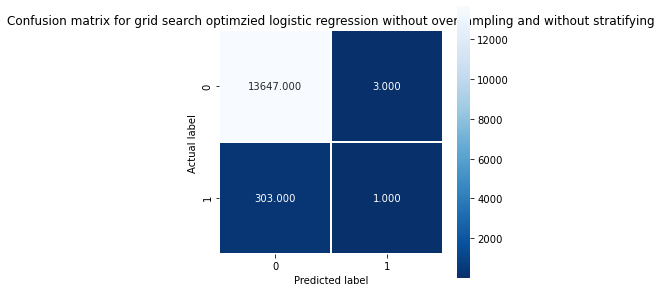

In [400]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test_ns, preds)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion matrix for grid search optimzied logistic regression without oversampling and without stratifying')
#plt.savefig('2.7.png')

From the confusion matrix we can see that a high number of the classes that were 0 were correctly predicted. However, there is a high number of instances that were 1 and were incorrectly labeled as 0. This means that the model misidentified donors as non-donors more than it misidentified non-donors as donors. This means that the model suffers from high Type II error but low Type I error

We can also plot the ROC Curve for this model.

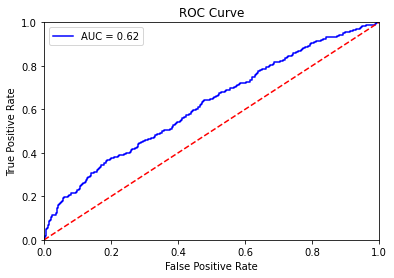

In [408]:
probs = log_reg.predict_proba(X_test_ns)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_ns, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'upper left')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig('2.8.png')
plt.show()


We can see that the ROC Curve is only slightly better than the dashed red line of the null model. The blue line would 
need to extend more toward the top left corner to be a better predictor of the likelihood of giving.

### 2.1. C: Feature selection using Random Forests and Lasso regression

#### Random Forests
We might be more interested in observing which of the features are important in the above case. We create instances and train both Random Forest Regression and Random Forest Classifier to observe which are more important in this case.



In [410]:
# Generating data for regression and performing random forest regression 
X, Y  = generate_data(c)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
feature_labels = X_train.columns
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test =sc.transform(X_test)

from sklearn.ensemble import RandomForestRegressor 
rf_reg = RandomForestRegressor(random_state=0)
rf_reg.fit(X_train, y_train.values.ravel())


RandomForestRegressor(random_state=0)

In [411]:
# Generating data for classifier and performing random forest classifer analysis 
X, Y  = generate_logistic_data(c)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
feature_labels = X_train.columns
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test =sc.transform(X_test)

from sklearn.ensemble import RandomForestClassifier 
rf_class = RandomForestClassifier(random_state=0)
rf_class.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=0)

In [412]:
feature_importance_data_reg = {'Feature_labels': feature_labels, \
                            'Feature_importance': rf_reg.feature_importances_}
feature_importance_data_reg = pd.DataFrame(feature_importance_data_reg)
feature_importance_data_reg.sort_values(by=['Feature_importance'], \
                                    ascending=False,inplace=True)


feature_importance_data_class = {'Feature_labels': feature_labels, \
                            'Feature_importance': rf_class.feature_importances_}
feature_importance_data_class = pd.DataFrame(feature_importance_data_class)
feature_importance_data_class.sort_values(by=['Feature_importance'], \
                                    ascending=False,inplace=True)


Text(0, 0.5, 'Feature name')

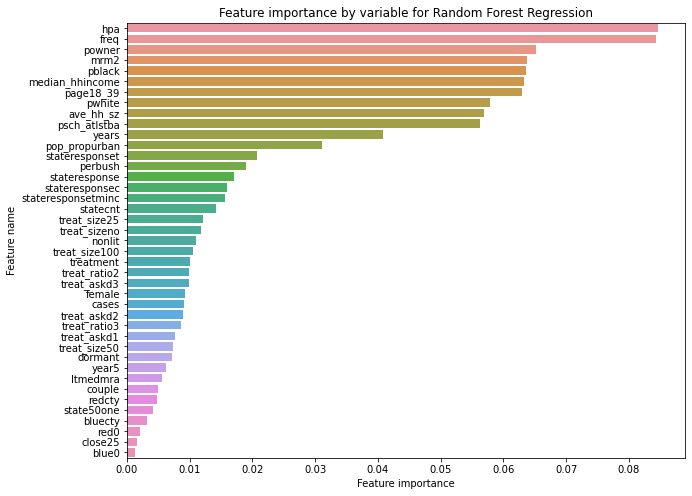

In [414]:
plt.figure(figsize=(10,8))
g = sns.barplot(x=feature_importance_data_reg['Feature_importance'], y=feature_importance_data_reg['Feature_labels'])

plt.title('Feature importance by variable for Random Forest Regression')
plt.xlabel('Feature importance')
plt.ylabel('Feature name')
#plt.savefig('2.9.png')
           

Text(0, 0.5, 'Feature name')

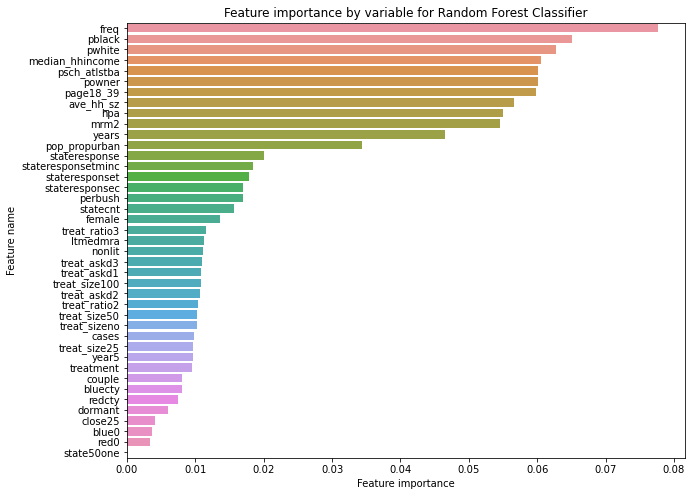

In [416]:
plt.figure(figsize=(10,8))
g = sns.barplot(x=feature_importance_data_class['Feature_importance'], y=feature_importance_data_class['Feature_labels'])

plt.title('Feature importance by variable for Random Forest Classifier')
plt.xlabel('Feature importance')
plt.ylabel('Feature name')
#plt.savefig('2.10.png')
           

It is worth noting that both plots are largely similar. From the feature importance plots , the following variables are important that were also significant in the linear regression coefficent analysis that we performed above:
- Freq (How often donor donates)
- Hpa (highest previous donation)
- mrm2 (Number of months since last donation)
- years (Numer of years since last donation)

In addition, the feature importance plot shows that the variable couple (whether the donation came from a couple) is not important, which is different from our coefficent analysis of linear regression. 

There are more variables that are identified by the Random Forest Regression feature importance plot that were not identified by regular regression. These include some demographic features such as 
- powner (percentage of homeowners in county)
- median_hhincome (median household income)
- page18_39 (proportion of people aged between 18- 39) 
- ave_hh_sz (average household size)

and more. 

Some of these variables are intuitively related to what we are trying to predict even if they are county level variables that do not give information about the specifc donor. For example, if an area is more well off, has more homeowners, and a higher proportion of people who are older and qualify for a mortgate, they may be more likely to donate than students or those with many dependents.


We can see that the following varaiables are important, although they are not extremely important but are important relative to each other

- Frequency (When last donated)
- Percentage of people in county who are owners
- Median household income
- Average household sizes 
- Percentage of school children with at least bachelors degree

Whereas the treatment variables, female variables, red and blue county variables did not seem to be very important.



#### Feature selection by Lasso

We can also attempt to do feature importance by Lasso Regression as it is also a form of feature selection. For this,
we get the absolute value of the coefficients of regression, and choose those features that are above a certain threshold (for example 0.1). We can then plot them in a graph.


In [417]:

X, Y  = generate_data(c)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test =sc.transform(X_test)

lasso = LassoCV().fit(X_train, y_train)
importance = np.abs(lasso.coef_)

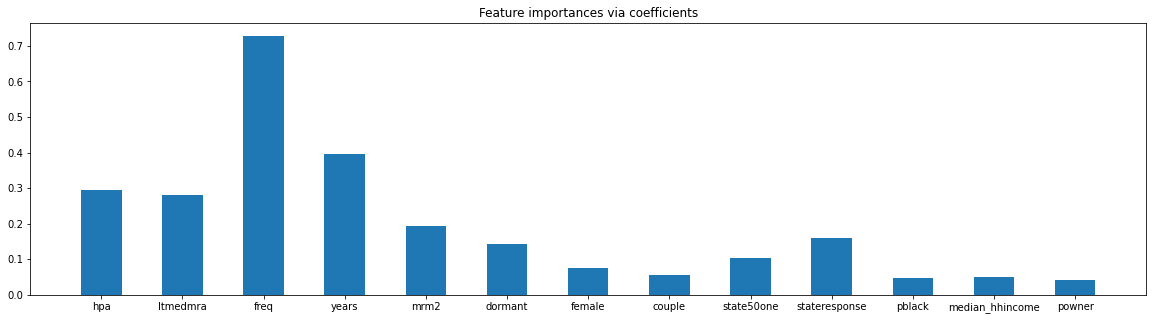

In [419]:
feature_names = np.array(feature_labels)
idxs_thresh = np.where(importance > 0.03)

importance_thresh, feature_names_thresh = importance[idxs_thresh], feature_names[idxs_thresh]
plt.figure(figsize=(20, 5))
plt.bar(height=importance_thresh, x=feature_names_thresh, width=0.5)
plt.title("Feature importances via coefficients")
#plt.savefig('2.11.png')
plt.show()

Using lasso regression, the variables largely align with what we saw in the Random Forest Regression method and the linear regression methods above.

## 2.2 : Statistical analysis of treatment groups

For the treatment group, donors received text in letters stating that their donation will be matched and in boldface what the details of the match should be. 

We first subset the data to the groups and treatments. 

### General treatment
The general treatment condition simply indicates if the donor will be assigned individual sub-treatments such as donation size suggestion, matching ratio etc.

In [424]:
condition_info = c2[['treatment', 'out_amountgive']]
treatment = condition_info[condition_info['treatment'] == 1][['out_amountgive']].reset_index()
treatment.rename(columns={'out_amountgive':'Treatment amount given'}, inplace=True)
treatment.drop(columns=['index'], inplace=True)

control = condition_info[condition_info['treatment'] == 0][['out_amountgive']].reset_index()
control.rename(columns={'out_amountgive':'Control amount given'}, inplace=True)
control.drop(columns=['index'], inplace=True)

treatment_vs_control = pd.concat([treatment,control], axis=1)

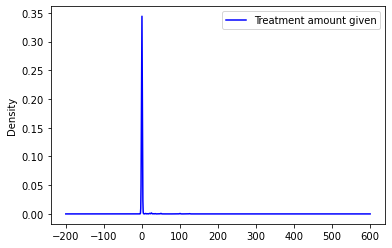

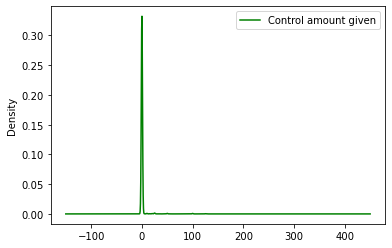

In [425]:
treatment.plot.kde(color='blue')
#plt.savefig('3.1.png')
control.plot.kde(color='green')
#plt.savefig('3.2.png')

From the above we can see that a similar proportion of members in each condition do not donate any amount or donate 0 dollars. 

It may be more useful to visualize only the non-zero donations of each group.

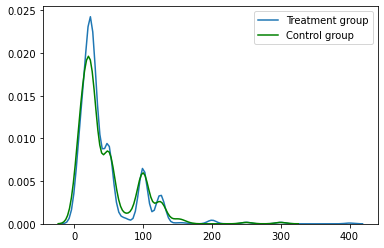

In [429]:
treatment_nonzero = treatment[treatment['Treatment amount given'] != 0]
control_nonzero = control[control['Control amount given'] != 0]

sns.distplot(treatment_nonzero, kde=True, hist=False, label='Treatment group')
sns.distplot(control_nonzero, kde=True,hist=False, label='Control group', color='green')
#plt.savefig('3.3.png')

From the above plot, we can tell that in the Treatment group, more people donate in the 0 - 100 price range. By and large, the donation in the treatment group seems to be larger than the control group

We can also do a hypothesis test to assess whether there is a difference in the mean contribution of two groups. 

$$H_{0} : u_{Treatment} - u_{Control} = 0$$
$$H_{0} : u_{Treatment} - u_{Control} \neq 0$$

We assume that the contributions of individuals in each group are independent of both members in their co-group and members in the other group. However, there may be a possibility that members consult with each other about donations. 

We also check the standard deviations of the two groups to see whether a two sample t-test using equal variance is appropriate.

In [513]:
print('Variance of treatment group: ', np.std(treatment['Treatment amount given'])**2)
print('Variance of control group: ',  np.std(control['Control amount given'])**2)

Variance of treatment group:  80.3367062524499
Variance of control group:  66.85085051274991


Thus we use unequal variance two sample t-testing here

In [520]:
import scipy.stats as ss
conf_level = 0.05
t_stat, p_val = ss.ttest_ind(treatment['Treatment amount given'], \
                           control['Control amount given'], equal_var=False)

In [521]:
p_val

0.05508556965377777

In [522]:
if p_val > 0.05:
    comparison = 'greater'
else:
    comparison = 'lesser'

if comparison == 'greater':
    result = 'fail to reject the null hypothesis'
else:
    result = 'reject the null hypothesis'

if result == 'fail to reject the null hypothesis':
    conclusion =  'no difference in the mean contributions of treatment vs control groups'
else:
    conclusion = 'there is a difference in the mean contributions of treatment vs control groups'

In [523]:
print("The p value {} is ".format(round(p_val, 4)), comparison, 'than our confidence level of {};\n'.format(conf_level),\
        'thus we', result, 'and conclude that', conclusion)

The p value 0.0551 is  greater than our confidence level of 0.05;
 thus we fail to reject the null hypothesis and conclude that no difference in the mean contributions of treatment vs control groups


### Matching ratio treatment
There are 3 matching ratio conditions that are offered to donors for every donation that they make. The first is 1:1 Ratio or 1:1 donation matching. The other two are 2:1 and 3:1 respectively. These conditions are within the original treatment condition and do not apply to the control group.

It would be interesting to see whether there is a difference between the type of donation matching condition and the amount of donation given. We can test these similarly using the two sample t_test method.



In [433]:
def generate_ratio_subset(data):
    subset_data = data[data['treatment'] == 1]    
    # Finding 1:1 ratio
    one_to_one = subset_data[subset_data['Ratio condition'] == '1:1 Ratio'][['out_amountgive']]
    one_to_one.reset_index(drop=True, inplace=True)
    not_one_to_one = subset_data[subset_data['Ratio condition'] != '1:1 Ratio'][['out_amountgive']]
    not_one_to_one.reset_index(drop=True, inplace=True)
    return one_to_one, not_one_to_one
        

In [434]:
ratio_1_1 , ratio_not_1_1 = generate_ratio_subset(c2)

First we can perform some EDA to observe differences.

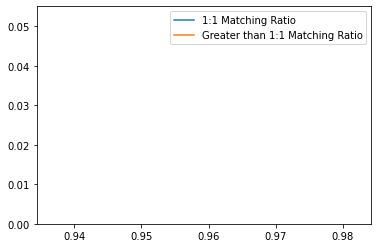

In [435]:
sns.distplot(ratio_1_1, kde=True, hist=False, label='1:1 Matching Ratio')
sns.distplot(ratio_not_1_1, kde=True,hist=False, label='Greater than 1:1 Matching Ratio')

We can see that as the default donation is 0 dollars thus we cannot visualize. We will have to re-subset the data to include variables greater than 0.

In [436]:
ratio_1_1_non_zero = ratio_1_1[ratio_1_1['out_amountgive'] != 0]
ratio_not_1_1_non_zero = ratio_not_1_1[ratio_not_1_1['out_amountgive'] != 0]

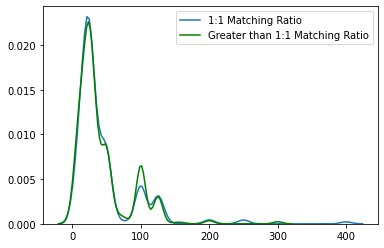

In [438]:
sns.distplot(ratio_1_1_non_zero, kde=True, hist=False, label='1:1 Matching Ratio')
sns.distplot(ratio_not_1_1_non_zero, kde=True,hist=False, label='Greater than 1:1 Matching Ratio', color='green')
#plt.savefig('3.4.png')

The distribution in both matching conditions seems to be identical, except for the greater than 1:1 Matching Ratios having more donations of 100$. However, this could just be due to the differing sizes of the two groups. We can use statistical hypothesis testing to verify this as well.

We have the following hypothesis for the treatment group:
$$H_{0} : u_{Treatment,  1:1 Ratio} - u_{Treatment, > 1:1 Ratio} = 0$$

$$H_{0} : u_{Treatment,  1:1 Ratio} - u_{Treatment,  1:1 Ratio} \neq 0$$

First, we need to find the variances of each subgroup to determine the type of two sample independent hypothesis testing to perform.

In [608]:
print('Variance of treatment group, 1:1 matching condition', \
          np.std(ratio_1_1['out_amountgive'])**2)
print('Variance of treatment group, greater than 1:1 matching condition', \
      np.std(ratio_1_1['out_amountgive'])**2)

Variance of treatment group, 1:1 matching condition 87.23258382278239
Variance of treatment group, greater than 1:1 matching condition 87.23258382278239


As the variances are unequal, we perform the unequal variance two sample t-testing.

In [610]:
conf_level = 0.05
t_stat, p_val = ss.ttest_ind(ratio_1_1['out_amountgive'], \
                           ratio_not_1_1['out_amountgive'], equal_var=False)

print('P value: {}'.format(p_val))

P value: 0.6698685990289445


In [611]:
if p_val > 0.05:
    comparison = 'greater'
else:
    comparison = 'lesser'

if comparison == 'greater':
    result = 'fail to reject the null hypothesis'
else:
    result = 'reject the null hypothesis'

if result == 'fail to reject the null hypothesis':
    conclusion =  'no difference in the mean contributions of 1:1 matching ratio vs greater than 1:1 matching ratio group'
else:
    conclusion = 'there is a difference in the mean contributions of  1:1 matching ratio vs greater than 1:1 matching ratio group'

In [612]:
print("The p value {} is ".format(round(p_val, 4)), comparison, 'than our confidence level of {};\n'.format(conf_level),\
        'thus we', result, 'and conclude that', conclusion)

The p value 0.6699 is  greater than our confidence level of 0.05;
 thus we fail to reject the null hypothesis and conclude that no difference in the mean contributions of 1:1 matching ratio vs greater than 1:1 matching ratio group


### Donation size suggestion treatment
In addition to the treatment vs. control group conditions and the matching ratio conditions, there is also a donation amount suggestion condition, where there is a suggestion to donate:
- the highest previous contribution
- 1.25 times the highest previous contribution
- 1.75 times the highest previous contribution

We can use hypothesis testing to see if there is a difference between suggesting to donate the highest previous contribution, or higher than that.

In [439]:
def generate_suggestion_data(data, treatment):
    subset = data[data.treatment == 1]

    def get_highest_previous_multiple(multiple, data_inp):
        #rename_cols = {}
        if multiple == 1:
            new_subset = data_inp[data_inp['treat_askd1'] == 1]
            return new_subset[['out_amountgive']]
        elif multiple == 1.25:
            new_subset = data_inp[data_inp['treat_askd2'] == 1]
            return new_subset[['out_amountgive']]
        elif multiple == 1.50:
            new_subset = data_inp[data_inp['treat_askd3'] == 1]
            return new_subset[['out_amountgive']]
        
        
    one, one_25, one_50  = get_highest_previous_multiple(1, subset), \
                            get_highest_previous_multiple(1.25, subset), \
                            get_highest_previous_multiple(1.50, subset)
    
    greater_than_one = pd.concat([one_25, one_50])
    

    return one, greater_than_one

In [440]:
treatment_suggestion_1, treatment_suggestion_greater_than_1 = generate_suggestion_data(c2, 'Treatment')

We have the following hypotheses to test the difference:

$$H_{0} : u_{Treatment, suggestion=1X} - u_{reatment, suggestion>1X} = 0$$
$$H_{0} : u_{Treatment, suggestion=1X} - u_{reatment, suggestion>1X} \neq 0$$

We first check the standard deviations of these two groups:


In [330]:
print('Variance of treatment group, 1 times highest previous contributon suggestion', \
          np.std(treatment_suggestion_1['out_amountgive'])**2)
print('Variance of treatment group, greater than 1 times highest previous contributon suggestion', \
      np.std(treatment_suggestion_greater_than_1['out_amountgive'])**2)

Variance of treatment group, 1 times highest previous contributon suggestion 71.1307821627952
Variance of treatment group, greater than 1 times highest previous contributon suggestion 84.93878802623898


We can proceed with assuming variance as unequal.

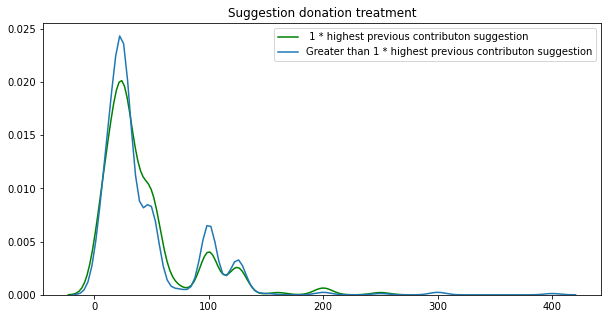

In [441]:
plt.figure(figsize=(10,5))
sns.distplot(treatment_suggestion_1[treatment_suggestion_1.out_amountgive > 0],  \
             kde=True, hist=False, label=' 1 * highest previous contributon suggestion', color='green')

sns.distplot(treatment_suggestion_greater_than_1[\
                        treatment_suggestion_greater_than_1.out_amountgive > 0], \
             kde=True,hist=False, label='Greater than 1 * highest previous contributon suggestion')
plt.title('Suggestion donation treatment')
plt.savefig('3.5.png')

It seems like donations increase with higher donation suggestions. We can formally test this using the hypotheses that we outlined above. 


In [732]:
conf_level = 0.05
t_stat, p_val = ss.ttest_ind(treatment_suggestion_1['out_amountgive'], \
                           treatment_suggestion_greater_than_1['out_amountgive'], equal_var=False)

print('P value: {}'.format(p_val))



P value: 0.42980333131081305


In [733]:
if p_val > 0.05:
    comparison = 'greater'
else:
    comparison = 'lesser'

if comparison == 'greater':
    result = 'fail to reject the null hypothesis'
else:
    result = 'reject the null hypothesis'

if result == 'fail to reject the null hypothesis':
    conclusion =  'no difference in the mean contributions of donors with donation suggestion of 1 * highest previous donation vs suggestion of greater donation'
else:
    conclusion = 'there is a difference in the mean contributions of donors with donation suggestion of 1 * highest previous donation vs suggestion of greater donation'

In [734]:
print("The p value {} is ".format(round(p_val, 4)), comparison, 'than our confidence level of {};\n'.format(conf_level),\
        'thus we', result, 'and conclude that', conclusion)

The p value 0.4298 is  greater than our confidence level of 0.05;
 thus we fail to reject the null hypothesis and conclude that no difference in the mean contributions of donors with donation suggestion of 1 * highest previous donation vs suggestion of greater donation


It does not look like any of the treatments were statistically significant when it comes to hypothesis testing.

We can subgroup the data and observe where the mean donations were higher or lower

### Grouped plots of treatments

In [311]:
treatment_data = c2[c2.treatment == 1]
groupby_cols = ['Ratio condition', 'Suggested donation size']
grouped = treatment_data.groupby(groupby_cols)['out_amountgive'].agg(['mean'])

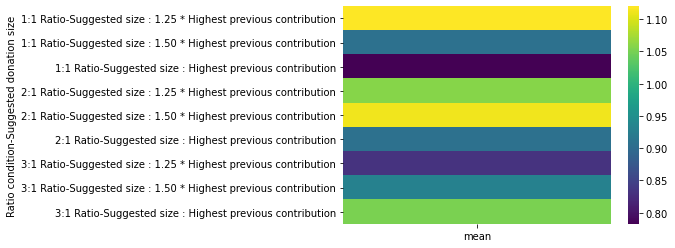

In [443]:
sns.heatmap(grouped, cmap='viridis')
#plt.savefig('3.6.png')

From the heatmap, we can see that the highest mean contributions occur when the donation matching ratio is 2:1 and when the suggested donation size is 1.5 times previous contribution. On the other hand, when the donation matching is 3:1 instead of 2:1, we observe lower donations on average.

We can also look at the maximum aggregation of these groups and observe patterns. 

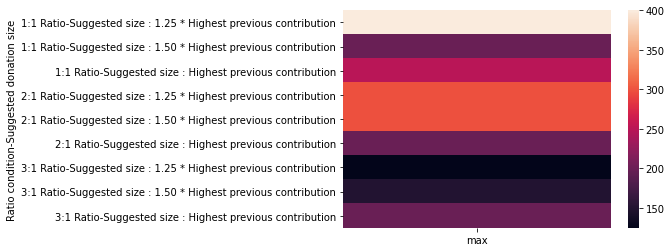

In [445]:
grouped_max = treatment_data.groupby(groupby_cols)['out_amountgive'].agg(['max'])
sns.heatmap(grouped_max)
#plt.savefig('3.7.png')

We can see that the pattern is slightly different in this condition. The highest donation is in the 2:1 matching ratio group and in the 1.25 suggested donation size group. This indicates some individuals may give more in lump sum in lower matching ratio conditions. 

Similar to the previous heatmap of aggregations, the 3:1 donation matching condition does not have donations as high as the matching conditions that are lower. 

# Conclusion

For my question about whether demographic variables such as gender of donor and racial composition of area can inform the amount donated, I found no statistical evidence that gender or racial composition can inform donation amounts. However, using EDA I could observe patterns that showed that female donation was lower than male contribution. In addition to gender and race, other demographic variables also showed no signficance in informing amount donated when it came to regressions, although they did stand out as important in the feature selection steps. 

For my question about whether the treatment conditions can signficantly change the amount donated, using hypothesis testing I found no evidence that changing the matching ratio (e.g. promising to match 3 times the donated amount) from a 1:1 setting to higher ratios impacted donations. The same is true for the changing suggeseted donation amount setting.  However, using EDA I could see that a 1:1 Ratio condition corresponded with higher donations, as did a donation suggestion of 1.25 times the previous amount. Similar to what the authors described in the paper, it may be that the donors were wary of conditions that they had no prior exposure to and may have thought a 3:1 matching unlikely. 

When it comes to finding what variables in general were important, variables specific to the behavior of the donor stood out. These included time since previous donations (month and years), highest previous contribution, etc. 


# Discussion
As there are multiple pairwise treatments that are happening in the data, there could be relationships that occur between two subgroups of treatment conditions that I did not check using hypothesis testing. However I was wary of doing too much hypothesis testing because multiple testing increases the likelihood of errors made with p-values. 

Visually, I saw that treatment conditions that had a high 'cost' (e.g. high donation suggestion amount) were associated with lower donation amount. On the other hand, treatment conditions that promised high matching and were 'against the norm' (such as 3:1 matching) had few high donations as well. This may indicate that individuals prefer a mix of the familiar with the affordable when it comes to making donations. 

In addition, the data was limited to many state and county level variables. Variables such as income, household size, number of children aged 18 - 39, race of donor could have been much more specific and may have had coefficients that were significantly different from 0 in the regressions.

The sample also is limited to a specific not-for-profit organization. According to a 2002 survey of its members, 70 percent of members are male, 60 percent are above 65 year of age, 80 percent have a college education, 30 percent are Christians. These numbers are not representative of the population in general and do not tell us much beyond the behavior of those who join not-for-profit organizations and contribute philanthropically.

# References

Karlan D, List JA. 2006. Does Price Matter in Charitable Giving? Evidence from a Large-Scale Natural Field Experiment. Working paper, Yale University. 